# **PREDICTING HOUSE PRICES**

**In this notebook, we are going to build a machine learning model that predicts prices of houses based on historical data.**

## Data: ##
The dataset we're gonna work with is the Ames Housing dataset. It contains 80 attributes for 2,930 properties in Ames, Iowa and was completed in 2011. The attributes include number and type of rooms, location specific data and special features of the property (pool, fireplace etc.). Each row in the dataset represents a single house.

## Goal: ##
Predict sale price of a house as accurately as possible, based on data about the house features and location.

## Models: ##


## Evaluation: ##


## Result: ##



Let's take a look at our training data:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import random
import warnings


In [3]:

# Import train and test data
house_train = pd.read_csv("./data/train.csv")
house_test = pd.read_csv("./data/test.csv")

In [4]:
# Take a look at the first 5 rows of the training data
house_train.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
house_test.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
# Take a look at additional info regarding the training data
house_data.info()

NameError: name 'house_data' is not defined

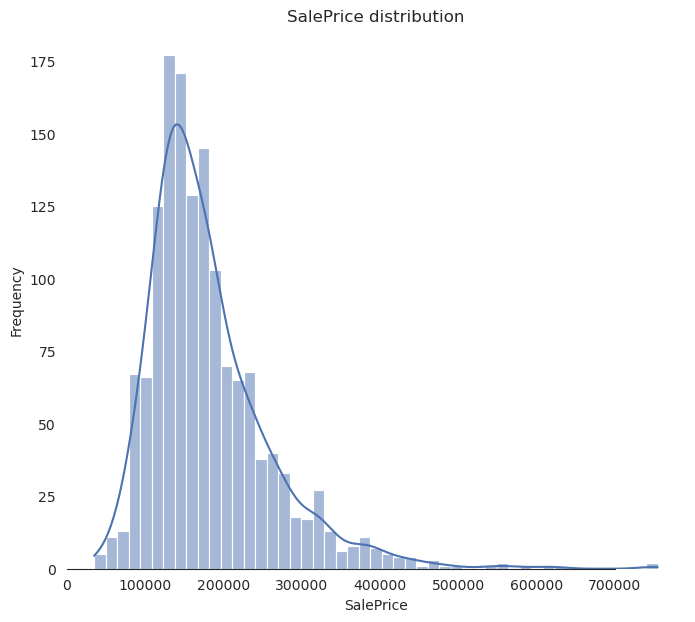

In [ ]:
# Plot a histogram of the target column (SalePrice)
sns.set_style("white")
sns.set_color_codes(palette = "deep")
fig, ax = plt.subplots(figsize = [8, 7])
sns.histplot(house_train["SalePrice"], kde = "True", color = "b") # kde: Kernel Density Estimate
                                                                  # not using displot because that's a figure-level function
ax.xaxis.grid(False)
ax.set(ylabel = "Frequency")
ax.set(xlabel = "SalePrice")
ax.set(title = "SalePrice distribution")
sns.despine(trim = True, left = True)
plt.show()


In [ ]:
# Look at how spread out and symmetric the graph is
print("Kurtosis: %f" % house_train["SalePrice"].kurt())
print("Skewness: %f" % house_train["SalePrice"].skew())

Kurtosis: 6.536282
Skewness: 1.882876



The kurtosis and skewness values tell us that the distribution has a pretty sharp peak and that it is "leaning" to the left, i. e., there is a high number of cheaper houses and there are a few extremely expensive ones.


Now, let's look at the features. Start by getting to know numeric features.



In [7]:
# Filter numeric features
numeric_datatypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_cols = []
for i in house_train.columns:
    if house_train[i].dtype in numeric_datatypes:
        if i in ['TotalSF', 'Total_Bathrooms','Total_porch_sf','haspool','hasgarage','hasbsmt','hasfireplace']:
            pass
        else:
            numeric_cols.append(i)     